In [121]:
# imports
from shutil import copyfileobj
from urllib import request
import pandas as pd
import uuid
import xlwings as xw
from xlwings import load
import re
import datetime
import pytz as tz
from bs4 import BeautifulSoup
import requests
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn import metrics

# Vendeeglobe

## 1 - Récupération de données

In [2]:
#%env XLWINGS_LICENSE_KEY=noncommercial
#!xlwings license update -k noncommercial

In [3]:
URL_DOMAIN = "https://www.vendeeglobe.org"
URL_CLASSEMENT = "https://www.vendeeglobe.org/fr/classement"
URL_DOWNLOAD = "/download-race-data/"
#URL_DOWNLOAD = "/download-race-data/vendeeglobe_20210305_080000.xlsx"
URL_VOILIERS = "https://www.vendeeglobe.org/fr/glossaire"

EXCEL_FILEPATH = './data/excel/'
CSV_FILEPATH = './data/csv/'

filename_arrivee = 'arrivee'
filename_exemple = 'exemple'

In [4]:
def read_xlsx_to_dataframe(filepath):
    excel_app = xw.App(visible=False)
    #excel_book = excel_app.books.open(filepath)
    excel_book = xw.Book(filepath, mode='r')
    sheet1 = excel_book.sheets[0]
    #cells = sheet1.used_range
    #df = cells.value
    #df = pd.DataFrame(sheet1.cells.value)
    df = sheet1.cells.options('df').value
    excel_book.close()
    excel_app.quit()
    df.columns = range(df.columns.size)
    df.reset_index(inplace=True, drop=True)
    #return pd.DataFrame(df)
    return df

def clean_all_null(df):
    
    cleaned_df = df.copy()
    
    none_rows = []
    for i in range(df.shape[0]):
        if pd.isnull(cleaned_df.iloc[i,:]).all():
            none_rows.append(i)
    if len(none_rows) > 0:
        cleaned_df.drop(none_rows,axis=0, inplace=True)
    
    none_columns = []
    for j in range(df.shape[1]):
        if pd.isnull(cleaned_df.iloc[:,j]).all():
            none_columns.append(j)
    if len(none_columns) > 0:
        cleaned_df.drop(none_columns,axis=1, inplace=True)
    
    cleaned_df.reset_index(inplace=True, drop=True)
    cleaned_df.columns = range(cleaned_df.columns.size)
    
    return cleaned_df

def separate_metadata(df):
    cleaned_df = df.copy()
    
    metadata = {}
    
    # get classement_date information
    metadata["classement_date"] = cleaned_df.iat[0,0]
    cleaned_df.iat[0,0] = None
    
    # get distance definition
    metadata["distance_definition"] = cleaned_df.iat[-1,0]
    cleaned_df.iat[-1,0] = None
    
    # get distance definition
    metadata["velocity_definition"] = cleaned_df.iat[-2,0]
    cleaned_df.iat[-2,0] = None
    
    # get calculation services
    metadata["calculation_services"] = cleaned_df.iat[-3,0]
    cleaned_df.iat[-3,0] = None
    
    return (cleaned_df, metadata)

In [5]:
#data = read_xlsx_to_dataframe(EXCEL_FILEPATH + filename_exemple + '.xlsx')

In [6]:
#cleaned_data = clean_all_null(data)
#cleaned_data, metadata = separate_metadata(cleaned_data)
#cleaned_data = clean_all_null(cleaned_data)

In [7]:
data_definition_arrivee = {
    0:{"header_alias":"Rang", "raw_headers":[(0,0)], "data_col":0, "data_start_row":2, "force_alias":False},
    1:{"header_alias":"Nat/Voile", "raw_headers":[(0,1)], "data_col":1, "data_start_row":2, "force_alias":False},
    2:{"header_alias":"Skipper/Bateau", "raw_headers":[(0,2)], "data_col":2, "data_start_row":2, "force_alias":False},
    3:{"header_alias":"Date d'Arrivée", "raw_headers":[(0,3)], "data_col":4, "data_start_row":2, "force_alias":False},
    4:{"header_alias":"Temps de course", "raw_headers":[(0,5)], "data_col":5, "data_start_row":2, "force_alias":False},
    5:{"header_alias":"Ecarts au premier", "raw_headers":[(0,6),(1,6)], "data_col":7, "data_start_row":2, "force_alias":False},
    6:{"header_alias":"Ecarts au précédent", "raw_headers":[(0,6),(1,8)], "data_col":9, "data_start_row":2, "force_alias":False},
    7:{"header_alias":"Sur l'ortho - Vitesse", "raw_headers":[(0,10),(1,10)], "data_col":10, "data_start_row":2, "force_alias":False},
    8:{"header_alias":"Sur l'ortho - Distance", "raw_headers":[(0,10),(1,11)], "data_col":11, "data_start_row":2, "force_alias":False},
    9:{"header_alias":"pourcentage", "raw_headers":[(0,12)], "data_col":12, "data_start_row":2, "force_alias":True},
    10:{"header_alias":"Sur le fond - Vitesse", "raw_headers":[(0,13),(1,13)], "data_col":13, "data_start_row":2, "force_alias":False},
    11:{"header_alias":"Sur le fond - Distance", "raw_headers":[(0,13),(1,14)], "data_col":14, "data_start_row":2, "force_alias":False}
}

data_definition = {
    0:{"header_alias":"rang", "raw_headers":[(0,0)], "data_col":0, "data_start_row":2, "force_alias":False},
    1:{"header_alias":"nat_voile", "raw_headers":[(0,1)], "data_col":1, "data_start_row":2, "force_alias":False},
    2:{"header_alias":"skipper_bateau", "raw_headers":[(0,2)], "data_col":2, "data_start_row":2, "force_alias":False},
    3:{"header_alias":"heure_fr", "raw_headers":[(1,3)], "data_col":3, "data_start_row":2, "force_alias":False},
    4:{"header_alias":"latitude", "raw_headers":[(1,4)], "data_col":4, "data_start_row":2, "force_alias":False},
    5:{"header_alias":"longitude", "raw_headers":[(1,5)], "data_col":5, "data_start_row":2, "force_alias":False},
    6:{"header_alias":"depuis_30_min_cap", "raw_headers":[(0,6),(1,6)], "data_col":6, "data_start_row":2, "force_alias":False},
    7:{"header_alias":"depuis_30_min_vitesse", "raw_headers":[(0,6),(1,7)], "data_col":7, "data_start_row":2, "force_alias":False},
    8:{"header_alias":"depuis_30_min_vmg", "raw_headers":[(0,6),(1,8)], "data_col":8, "data_start_row":2, "force_alias":False},
    9:{"header_alias":"depuis_30_min_distance", "raw_headers":[(0,6),(1,9)], "data_col":9, "data_start_row":2, "force_alias":False},
    10:{"header_alias":"depuis_dernier_classement_cap", "raw_headers":[(0,10),(1,10)], "data_col":10, "data_start_row":2, "force_alias":False},
    11:{"header_alias":"depuis_dernier_classement_vitesse", "raw_headers":[(0,10),(1,11)], "data_col":11, "data_start_row":2, "force_alias":False},
    12:{"header_alias":"depuis_dernier_classement_vmg", "raw_headers":[(0,10),(1,12)], "data_col":12, "data_start_row":2, "force_alias":False},
    13:{"header_alias":"depuis_dernier_classement_distance", "raw_headers":[(0,10),(1,13)], "data_col":13, "data_start_row":2, "force_alias":False},
    14:{"header_alias":"depuis_24_heure_cap", "raw_headers":[(0,14),(1,14)], "data_col":14, "data_start_row":2, "force_alias":False},
    15:{"header_alias":"depuis_24_heure_vitesse", "raw_headers":[(0,14),(1,15)], "data_col":15, "data_start_row":2, "force_alias":False},
    16:{"header_alias":"depuis_24_heure_vmg", "raw_headers":[(0,14),(1,16)], "data_col":16, "data_start_row":2, "force_alias":False},
    17:{"header_alias":"depuis_24_heure_distance", "raw_headers":[(0,14),(1,17)], "data_col":17, "data_start_row":2, "force_alias":False},
    18:{"header_alias":"dtf", "raw_headers":[(0,18)], "data_col":18, "data_start_row":2, "force_alias":False},
    19:{"header_alias":"dtl", "raw_headers":[(0,19)], "data_col":19, "data_start_row":2, "force_alias":False}
}

In [8]:
def format_header(df, data_definition, use_alias):
    
    formatted_df = pd.DataFrame()
    
    for key in data_definition.keys():
        
        data_r = data_definition[key]["data_start_row"]
        data_c = data_definition[key]["data_col"]
        force_alias = data_definition[key]["force_alias"]
        
        if use_alias or force_alias:
            alias = data_definition[key]["header_alias"]
            formatted_df[alias] = df[data_c].iloc[data_r:]
        else:
            raw_header = ""
            for indices in data_definition[key]["raw_headers"]:
                raw_header = raw_header + df.iloc[indices[0], indices[1]]
                
            formatted_df[raw_header] = df[data_c].iloc[data_r:]
            
    formatted_df.reset_index(inplace=True, drop=True)
    
    return formatted_df

#formatted_header_data = format_header(cleaned_data, data_definition, True)


In [9]:
def format_rang(df, rang_col_name):
    if rang_col_name in df.columns:
        df[rang_col_name] = df[rang_col_name].str.replace('\nARV','')
        df[rang_col_name] = df[rang_col_name].str.replace('RET',str(-1))
        
#format_rang(formatted_header_data, 'rang')

def format_nat_voile(df, nat_voile_col_name, nat_col_name, voile_col_name):
    if nat_voile_col_name in df.columns:
        df[nat_voile_col_name] = df[nat_voile_col_name].str.replace('\n',' ')
        df[nat_voile_col_name] = df[nat_voile_col_name].str.upper()
        df[nat_col_name] = df[nat_voile_col_name].str.extract(r'([A-Z]+)')
        df[voile_col_name] = df[nat_voile_col_name].str.extract(r'([0-9]+)')
        df.drop(nat_voile_col_name, axis=1, inplace=True)

#format_nat_voile(formatted_header_data, 'nat_voile', 'nationalite', 'voile')

def format_skipper_bateau(df, skipper_bateau_col_name, skipper_col_name, bateau_col_name):
    if skipper_bateau_col_name in df.columns:
        df[skipper_col_name] = df[skipper_bateau_col_name].str.split('\r\n').apply(lambda x: x[0])
        df[bateau_col_name] = df[skipper_bateau_col_name].str.split('\r\n').apply(lambda x: x[1])
        df.drop(skipper_bateau_col_name, axis=1, inplace=True)
    
#format_skipper_bateau(formatted_header_data, 'skipper_bateau', 'skipper', 'bateau')


In [10]:
def format_date_classement(metadata):
    classement_date = metadata['classement_date']
    
    months_dict = {
        'janvier':'01',
        'février':'02',
        'mars':'03',
        'avril':'04',
        'mai':'05',
        'juin':'06',
        'juillet':'07',
        'août':'08',
        'septembre':'09',
        'octobre':'10',
        'novembre':'11',
        'décembre':'12'
    }
    
    day_pattern = re.compile('lundi|mardi|mercredi|jeudi|vendredi|samedi|dimanche')
    month_pattern = re.compile('janvier|février|mars|avril|mai|juin|juillet|août|septembre|octobre|novembre|décembre')
    
    day = re.search(day_pattern, classement_date).group()
    date = re.search('[0-9]+', re.search(' [0-9][0-9]? ', classement_date).group()).group()
    month = re.search(month_pattern, classement_date).group()
    year = re.search('[0-9]{4}', classement_date).group()
    dd_mm_yyyy = str(date) + '/' + str(months_dict[month]) + '/' + str(year)

    time_place = re.search('[0-9]{2}h[0-9]{2} [A-Z]+', classement_date).group()
    time = re.search('[0-9]{2}h[0-9]{2}', time_place).group().replace('h',':')
    place = re.search('[A-Z]+', time_place).group()

    metadata['day'] = day
    metadata['date'] = date
    metadata['month'] = month
    metadata['year'] = year
    metadata['dd_mm_yyyy'] = dd_mm_yyyy
    metadata['time'] = time
    metadata['place'] = place

#format_date_classement(metadata)


In [11]:
def format_heure_fr(df, date, heure_fr_col_name):
    #fr_tz = timezone('Europe/Paris')
    #datetime.tzinfo('Europe/Paris')
    if str(type(df['heure_fr'][0])) != "<class 'pandas._libs.tslibs.timestamps.Timestamp'>":
        df[heure_fr_col_name] = df[heure_fr_col_name].replace('[0-9]+min','',regex=True)
        df[heure_fr_col_name] = df[heure_fr_col_name].str.replace('-','')
        df[heure_fr_col_name] = df[heure_fr_col_name].str.replace('\r','')
        df[heure_fr_col_name] = df[heure_fr_col_name].str.replace('\n','')
        df[heure_fr_col_name] = pd.to_datetime(date +' '+ df[heure_fr_col_name])
        
#format_heure_fr(formatted_header_data, metadata['dd_mm_yyyy'], 'heure_fr')

def format_cap(df, cap_column):
    if cap_column in df.columns:
        #df[cap_column] = df[cap_column].str.extract(r'([0-9]+)')
        df[cap_column] = df[cap_column].str.replace('°','')
        
#format_cap(formatted_header_data, 'depuis_30_min_cap')
#format_cap(formatted_header_data, 'depuis_dernier_classement_cap')
#format_cap(formatted_header_data, 'depuis_24_heure_cap')

def format_vitesse(df, vitesse_column):
    if vitesse_column in df.columns:
        #df[vitesse_column] = df[vitesse_column].str.extract(r'([0-9\.]+)')
        df[vitesse_column] = df[vitesse_column].str.replace(' ','')
        df[vitesse_column] = df[vitesse_column].str.replace('kts','')
        
#format_vitesse(formatted_header_data, 'depuis_30_min_vitesse')
#format_vitesse(formatted_header_data, 'depuis_dernier_classement_vitesse')
#format_vitesse(formatted_header_data, 'depuis_24_heure_vitesse')
#format_vitesse(formatted_header_data, 'depuis_30_min_vmg')
#format_vitesse(formatted_header_data, 'depuis_dernier_classement_vmg')
#format_vitesse(formatted_header_data, 'depuis_24_heure_vmg')

def format_distance(df, distance_column):
    if distance_column in df.columns:
        #df[distance_column] = df[distance_column].str.extract(r'([0-9\.]+)')
        df[distance_column] = df[distance_column].str.replace(' ','')
        df[distance_column] = df[distance_column].str.replace('nm','')
        
#format_distance(formatted_header_data, 'depuis_30_min_distance')
#format_distance(formatted_header_data, 'depuis_dernier_classement_distance')
#format_distance(formatted_header_data, 'depuis_24_heure_distance')
#format_distance(formatted_header_data, 'dtf')
#format_distance(formatted_header_data, 'dtl')


In [12]:
def save_dataframe_to_csv(df, filepath):
    df.to_csv(filepath, index=False)
    
#save_dataframe_to_csv(formatted_header_data, CSV_FILEPATH+filename_exemple+'.csv')


In [13]:
def read_csv_to_dataframe(filepath):
    return pd.read_csv(filepath)

#read_csv_to_dataframe(CSV_FILEPATH+filename_exemple+'.csv')


In [14]:
# download excel file from url
#with request.urlopen(URL_DOMAIN + URL_DOWNLOAD) as response, open('./data/excel/exemple.xlsx', 'wb') as out_file:
#    copyfileobj(response, out_file)
    

In [15]:
def get_excel_filenames_from_website(url):
    
    excel_file_names = []
    r = requests.get(url)
    
    if r.status_code != 200:
        raise Exception('Error: Status Code:' + r.status_code)
    
    soup = BeautifulSoup(r.content)
    option_tag_array = soup.find_all('option')
    
    if option_tag_array[0].text != 'Précédents classements':
        raise Exception('Webpage content changed, Précédents classements expected, got ' + option_tag_array[0].text + ' instead')
    
    for element in option_tag_array[1:]:
        excel_file_names.append('vendeeglobe_' + element['value'] + '.xlsx')
        
    return excel_file_names


In [16]:
def download_classement_file(filename):
    
    url = URL_DOMAIN + URL_DOWNLOAD + filename
    download_file(url, EXCEL_FILEPATH + filename)
    
def download_file(url, filename):
    with request.urlopen(url) as response, open(filename, 'wb') as out_file:
        copyfileobj(response, out_file)
    
#for file in files_to_download:
#    download_classement_file(file)

    

In [17]:
def download_clean_save_csv_classement_file(filename):
    print(filename)
    # download xlsx
    download_classement_file(filename)
    # read xlsx
    data = read_xlsx_to_dataframe(EXCEL_FILEPATH + filename)
    # clean xlsx rows and columns
    cleaned_data = clean_all_null(data)
    cleaned_data, metadata = separate_metadata(cleaned_data)
    cleaned_data = clean_all_null(cleaned_data)
    
    # detect fichier arrivee
    if cleaned_data.iloc[0, 3] is not None and 'arrivée' in cleaned_data.iloc[0, 3]:
        print("fichier date d'arrivée: " + filename)
        return 
    
    # format header
    formatted_header_data = format_header(cleaned_data, data_definition, True)
    
    # format columns
    format_rang(formatted_header_data, 'rang')
    format_nat_voile(formatted_header_data, 'nat_voile', 'nationalite', 'voile')
    format_skipper_bateau(formatted_header_data, 'skipper_bateau', 'skipper', 'bateau')
    format_date_classement(metadata)
    format_heure_fr(formatted_header_data, metadata['dd_mm_yyyy'], 'heure_fr')
    format_cap(formatted_header_data, 'depuis_30_min_cap')
    format_cap(formatted_header_data, 'depuis_dernier_classement_cap')
    format_cap(formatted_header_data, 'depuis_24_heure_cap')
    format_vitesse(formatted_header_data, 'depuis_30_min_vitesse')
    format_vitesse(formatted_header_data, 'depuis_dernier_classement_vitesse')
    format_vitesse(formatted_header_data, 'depuis_24_heure_vitesse')
    format_vitesse(formatted_header_data, 'depuis_30_min_vmg')
    format_vitesse(formatted_header_data, 'depuis_dernier_classement_vmg')
    format_vitesse(formatted_header_data, 'depuis_24_heure_vmg')
    format_distance(formatted_header_data, 'depuis_30_min_distance')
    format_distance(formatted_header_data, 'depuis_dernier_classement_distance')
    format_distance(formatted_header_data, 'depuis_24_heure_distance')
    format_distance(formatted_header_data, 'dtf')
    format_distance(formatted_header_data, 'dtl')
    # save to csv
    save_dataframe_to_csv(formatted_header_data, CSV_FILEPATH + filename.replace('.xlsx','.csv'))


In [18]:
#csv_files = os.listdir(CSV_FILEPATH)
#download_clean_save_csv_classement_file(csv_files[0].replace('.csv','.xlsx'))
#df1 = read_csv_to_dataframe(CSV_FILEPATH + csv_files[0])

In [145]:
def download_files_convert_csv(start_filename=None, stop_filename=None):
    
    files_to_download = get_excel_filenames_from_website(URL_CLASSEMENT)
    
    if start_filename is not None or stop_filename is not None:
        index_start_filename = files_to_download.index(start_filename)
        index_stop_filename = files_to_download.index(stop_filename) + 1
        files_to_download = files_to_download[index_start_filename: index_stop_filename]
        
    for file in files_to_download:
        download_clean_save_csv_classement_file(file)
        
#download_files_convert_csv('vendeeglobe_20210127_140000.xlsx', 'vendeeglobe_20201108_120200.xlsx')

In [27]:
def get_all_csv_data(csv_file_path):
    
    csv_files = os.listdir(csv_file_path)
    
    all_data = pd.DataFrame()
    
    for file in csv_files:
        file_df = read_csv_to_dataframe(csv_file_path + file)
        all_data = pd.concat([all_data, file_df], axis=0)
        
    return all_data

classement_data = get_all_csv_data(CSV_FILEPATH)

In [28]:
classement_data

,rang,heure_fr,latitude,longitude,depuis_30_min_cap,depuis_30_min_vitesse,depuis_30_min_vmg,depuis_30_min_distance,depuis_dernier_classement_cap,depuis_dernier_classement_vitesse,...,depuis_24_heure_cap,depuis_24_heure_vitesse,depuis_24_heure_vmg,depuis_24_heure_distance,dtf,dtl,nationalite,voile,skipper,bateau
0,1,2021-11-01 11:30:00,25°13.94'S,38°29.15'W,65.0,9.8,7.1,4.9,67.0,5.4,...,18.0,5.9,5.9,142.6,4786.7,0.0,FRA,17,Yannick Bestaven,Maître Coq IV
1,2,2021-11-01 11:30:00,26°55.27'S,36°07.32'W,20.0,1.6,1.6,0.8,28.0,9.7,...,26.0,12.5,12.5,300.6,4835.8,49.1,FRA,79,Charlie Dalin,APIVIA
2,3,2021-11-01 11:30:00,28°17.65'S,36°20.90'W,31.0,17.2,16.9,8.6,28.0,17.2,...,32.0,12.8,12.6,307.9,4917.4,130.7,FRA,59,Thomas Ruyant,LinkedOut
3,4,2021-11-01 11:30:00,28°49.56'S,35°02.22'W,26.0,18.4,18.3,9.2,17.0,15.7,...,13.0,11.0,10.9,264.1,4924.2,137.6,FRA,1000,Damien Seguin,Groupe APICIL
4,5,2021-11-01 11:30:00,29°28.19'S,35°10.29'W,8.0,16.6,16.3,8.3,19.0,15.7,...,6.0,13.2,12.9,317.5,4963.1,176.4,FRA,18,Louis Burton,Bureau Vallée 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,29,2020-11-18 17:30:00,26°43.11'N,23°51.39'W,192.0,15.1,14.9,7.5,197.0,12.7,...,218.0,8.6,7.4,206.7,22802.9,1570.2,FR,69,Sébastien Destremau,Merci
29,30,2020-11-18 17:30:00,26°56.06'N,24°07.77'W,198.0,13.2,12.7,6.6,196.0,12.5,...,212.0,8.4,7.5,200.6,22815.3,1582.6,FRA,83,Clément Giraud,Compagnie du lit - Jiliti
30,31,2020-11-18 17:30:00,29°53.28'N,25°45.99'W,196.0,15.1,14.4,7.6,188.0,15.6,...,215.0,12.5,10.8,299.3,22992.4,1759.6,FRA,56,Fabrice Amedeo,Newrest - Art et Fenetres
31,32,2020-11-18 17:30:00,45°19.18'N,07°41.13'W,220.0,17.5,17.1,8.8,231.0,11.7,...,253.0,10.6,10.3,253.6,24069.6,2836.9,FRA,8,Jérémie Beyou,Charal


## 2 - Peut-on prédire le classement grâce à la vitesse utile (VMG)? 

In [132]:
X_y = classement_data[classement_data['rang'] != -1][['depuis_dernier_classement_vmg', 'rang']].dropna()
X = X_y['depuis_dernier_classement_vmg']
y = X_y['rang']


In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
y_train=y_train.astype('int')
y_test=y_test.astype('int')
#standard_scaler = preprocessing.StandardScaler().fit(pd.DataFrame(X_train))
#X_train = standard_scaler.transform(pd.DataFrame(X_train))
#X_test = standard_scaler.transform(pd.DataFrame(X_test))


In [134]:
predict_rank_from_vmg_model = LogisticRegression().fit(pd.DataFrame(X_train), y_train)
predicted_rank_from_vmg = predict_rank_from_vmg_model.predict(pd.DataFrame(X_test))


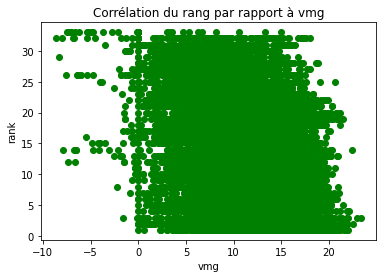

In [144]:
fig_corr_vmg_rank = plt.figure()
plt.scatter(X, y, color='green', label='rang')
plt.xlabel("vmg")
plt.ylabel("rank")
plt.title("Corrélation du rang par rapport à vmg")
plt.show()

En visualisant la vitesse utile (vmg) et le rang, nous voyons qu'il existe une faibe co-relation entre ces deux quantités.

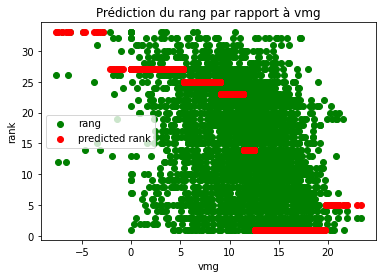

In [143]:
fig_logistic_regression = plt.figure()
plt.scatter(X_test, y_test, color='green', label='rang')
plt.scatter(X_test, predicted_rank_from_vmg, color='red', label='predicted rank')
plt.xlabel("vmg")
plt.ylabel("rank")
plt.title("Prédiction du rang par rapport à vmg")
plt.legend()
plt.show()

In [138]:
predict_rank_from_vmg_model_score = predict_rank_from_vmg_model.score(pd.DataFrame(X_test), y_test)
predict_rank_from_vmg_model_score

0.04319906596614127

En effet, en construisant un modèle de Regression Logistique pour prédire le rang, nous obtenons un accurancy de 4%. Sur la figure ci-dessus nous pouvons comparer la prédiction de notre modèle (en rouge) et les vrai rang (en vert). 

In [131]:
metrics.confusion_matrix?

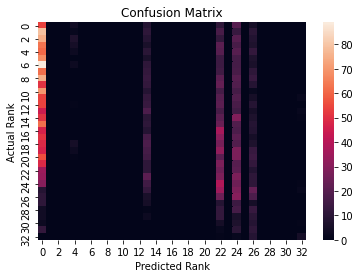

In [142]:
confusion_matrix_vmg_rank = metrics.confusion_matrix(y_test, predicted_rank_from_vmg)
sns.heatmap(confusion_matrix_vmg_rank)
plt.ylabel('Actual Rank');
plt.xlabel('Predicted Rank');
plt.title("Confusion Matrix")
plt.show()

La matrice de confusion ci-dessus nous permet aussi de voir que le modèle linéaire n'est pas très performant.